### Notebook for testing :

>ARIMA, 
>ARIMAX, 
>SARIMAX, 
>Smoothing exp and
>Winterhalt

In [1]:
import pandas as pd
import numpy as np 

import statsmodels.api as sm
import seaborn as sns
sns.set(style="darkgrid")
import matplotlib.pyplot as plt
sns.set(rc={'figure.figsize':(11.7,8.27)})

'''Predefined Functions for EDA'''
def eda(data):
    print("----------Top-5- Record----------")
    print(data.head(5))
    print("-----------Information-----------")
    print(data.info())
    print("-----------Data Types-----------")
    print(data.dtypes)
    print("----------Missing value-----------")
    print(data.isnull().sum())
    print("----------Null value-----------")
    print(data.isna().sum())
    print("----------Shape of Data----------")
    print(data.shape)
def graph_insight(data):
    print(set(data.dtypes.tolist()))
    df_num = data.select_dtypes(include = ['float64', 'int64'])
    df_num.hist(figsize=(16, 16), bins=50, xlabelsize=8, ylabelsize=8);
def drop_duplicate(data, subset):
    print('Before drop shape:', data.shape)
    before = data.shape[0]
    data.drop_duplicates(subset,keep='first', inplace=True) #subset is list where you have to put all column for duplicate check
    data.reset_index(drop=True, inplace=True)
    print('After drop shape:', data.shape)
    after = data.shape[0]
    print('Total Duplicate:', before-after)


In [2]:
shops=pd.read_csv('data/predict_future_sales/shops.csv')
train=pd.read_csv('data/predict_future_sales/sales_train.csv')
items=pd.read_csv('data/predict_future_sales/items.csv')
items_categories=pd.read_csv('data/predict_future_sales/item_categories.csv')
test=pd.read_csv('data/predict_future_sales/test.csv')
sample=pd.read_csv('data/predict_future_sales/sample_submission.csv')
items_categories['item_category_name']=items_categories['item_category_name'].astype(str)

In [3]:
items_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [4]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [5]:
items_categories['meta-category']=items_categories['item_category_name'].apply(lambda x : x.split("-")[0])

In [6]:
len(items_categories['meta-category'].unique())

21

In [7]:
items_categories.shape

(84, 3)

##### After grouping the category, we reduced the number from 84 to 21 

In [8]:
train['date']=pd.to_datetime(train.date,format='%d.%m.%Y')
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [9]:
train=train[~train.duplicated()]
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [10]:
train = train[(train.item_price > 0) & (train.item_price < 300000)]


In [11]:
train.date=train.date.apply(lambda x: x.strftime('%Y-%m'))

In [12]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01,0,59,22154,999.00,1.0
1,2013-01,0,25,2552,899.00,1.0
2,2013-01,0,25,2552,899.00,-1.0
3,2013-01,0,25,2554,1709.05,1.0
4,2013-01,0,25,2555,1099.00,1.0


In [13]:
df = train.groupby(['date','item_id','shop_id']).agg({'item_cnt_day':sum,
                                                     'item_price': 'mean'}).reset_index()
df = df[['date','item_id','shop_id','item_cnt_day']]
df = df.pivot_table(index=['item_id','shop_id'], columns='date',values='item_cnt_day',fill_value=0).reset_index()
df.head()


date,item_id,shop_id,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,...,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10
0,0,54,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,55,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,54,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,54,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,54,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
df[df['item_id']==50]

date,item_id,shop_id,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,...,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10
671,50,25,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
672,50,54,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
df_test = pd.merge(test, df, on=['item_id','shop_id'], how='left')
df_test = df_test.fillna(0)
df_test.head()

,ID,shop_id,item_id,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,...,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10
0,0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
## bring the metacategory to the item table 
from sklearn import preprocessing


items = pd.merge(items,items_categories, on=['item_category_id'], how='left')
items=items[['item_id','meta-category']]
le = preprocessing.LabelEncoder()
le.fit(items['meta-category'])
items['meta-category']=le.transform(items['meta-category'])
items.head()

,item_id,meta-category
0,0,11
1,1,15
2,2,11
3,3,11
4,4,11


In [17]:
df_test = pd.merge( df_test,items, on=['item_id'], how='left')
df_test.head()

,ID,shop_id,item_id,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,...,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10,meta-category
0,0,5,5037,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0,5
1,1,5,5320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13
2,2,5,5233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0,5
3,3,5,5232,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5
4,4,5,5268,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5


In [18]:
df_test = df_test.drop(labels=['ID', 'shop_id', 'item_id','meta-category'], axis=1)

df_test.head()

,2013-01,2013-02,2013-03,2013-04,2013-05,2013-06,2013-07,2013-08,2013-09,2013-10,...,2015-01,2015-02,2015-03,2015-04,2015-05,2015-06,2015-07,2015-08,2015-09,2015-10
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,1.0,1.0,1.0,3.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,3.0,2.0,0.0,1.0,3.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [19]:
df_test.shape

(214200, 34)

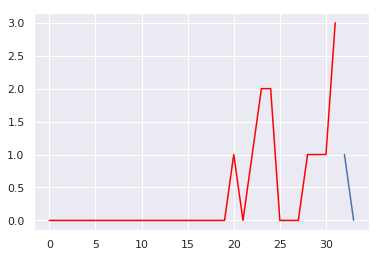

In [20]:
sns.lineplot(x=[a for a in range(df_test.shape[1]-2)],y=df_test.iloc[0][:-2].values,color='red')
sns.lineplot(x=[32,33],y=df_test.iloc[0][-2:].values)

### Soution 1, predict the same as last month

In [21]:
# Get the test set predictions and clip values to the specified range
y_pred = df_test['2015-10'].values.clip(0., 20.)

# Create the submission file and submit!
preds = pd.DataFrame(y_pred, columns=['item_cnt_month'])
preds.to_csv('submission.csv',index_label='ID')

### Solution 2 : facebook prophet

In [22]:
from fbprophet import Prophet


In [23]:
ds=[x+'-01' for x in df_test.columns.tolist()]

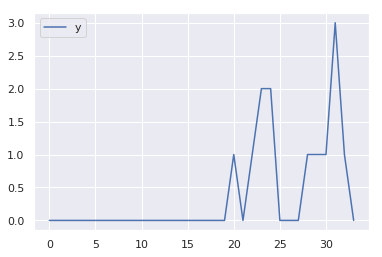

In [47]:
sample_df=pd.DataFrame.from_dict({'ds':ds,'y':df_test.iloc[0]})
sample_df=sample_df.reset_index(drop=True)
sample_df.plot()

In [41]:
# Setup and train model
model = Prophet()
model.fit(sample_df)
future = model.predict(pd.DataFrame.from_dict({'ds':['2015-11-01']}))

In [42]:
future

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-11-01,5.181823,2.48664,5.657276,5.181823,5.181823,-1.012755,-1.012755,-1.012755,-1.012755,-1.012755,-1.012755,0.0,0.0,0.0,4.169068


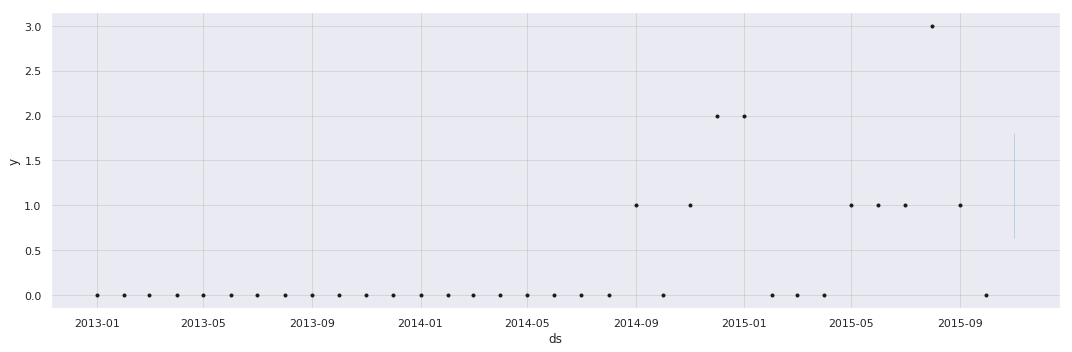

In [27]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
fig = model.plot(future, ax=ax)


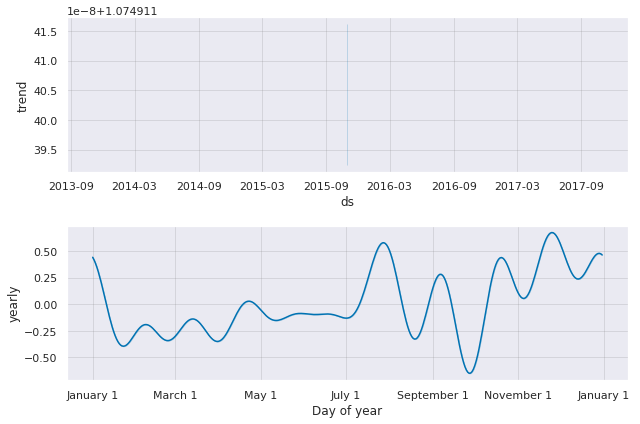

In [28]:
# Plot the components
fig = model.plot_components(future)


##### Run throughh all test set 

## Taking too much time,...

In [85]:
%%time
import warnings
warnings.filterwarnings('ignore')
#Supress default INFO logging

'''import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

## fill all pred with 0 at the beginnig
# fill the ds once as its the same for all the data 
y_pred=[0 for x in range(df_test.shape[0])]
ds=[x+'-01' for x in df_test.columns.tolist()]
for x in range(df_test.shape[0]):
    model = Prophet()
    model.fit(pd.DataFrame.from_dict({'ds':ds,'y':df_test.iloc[x]}).reset_index(drop=True))
    y_pred[x]=model.predict(pd.DataFrame.from_dict({'ds':['2015-11-01']}))['yhat'].values[0]
    if(x%50000==0):
        print (x)'''

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 19.8 µs


### Winter Halt, exp smoothing

In [ ]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
SimpleExpSmoothing, Holt

y_pred_halt=[0 for x in range(df_test.shape[0])]
y_pred_exp=[0 for x in range(df_test.shape[0])]
for x in range(df_test.shape[0]):
    y_pred_halt[x]=Holt(df_test.iloc[x].values).fit(smoothing_level = 0.3,smoothing_slope = 0.1).forecast(1)[0]
    #y_pred_exp[x]=ExponentialSmoothing(df_test.iloc[x].values ,seasonal_periods=12 ,trend='add', seasonal='add',).fit().forecast(1)[0]
    if(x%10000==0):
        print(x)

In [82]:
## halt model submit 
preds = pd.DataFrame(np.array(y_pred_halt1).clip(0., 20.), columns=['item_cnt_month'])
preds.to_csv('submission.csv',index_label='ID')